<a href="https://colab.research.google.com/github/johnsonAyo/aGent_analyst/blob/main/Agent_Analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Retrieval-Augmented Generation (RAG) Assisted Data Analyst Agent with Cohere and Langchain

In this notebook, we'll see how we can use two tools to create a simple data analyst agent that is able to search the web and run code in a python interpreter. This agent uses Cohere's Command R+ mode and Langchain

**Install the required Libaries**

In [8]:

! pip install --quiet langchain langchain_cohere langchain_experimental


In [7]:
pip install transformers==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


Cohere API key here is needed to access the LLM

In [9]:
#### LLMs
import os
os.environ['COHERE_API_KEY'] = "<YOUR_COHERE_API_KEY>"

In [10]:
# Create the Cohere chat model
from langchain_cohere.chat_models import ChatCohere
chat = ChatCohere(model="command-r-plus", temperature=0.3)

 Tivaly API serves as the agent that will access the web (search tool)

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ['TAVILY_API_KEY'] = "<YOUR_TAVILY_API_KEY>"

internet_search = TavilySearchResults()
internet_search.name = "internet_search"
internet_search.description = "Returns a list of relevant document snippets for a textual query retrieved from the internet."


from langchain_core.pydantic_v1 import BaseModel, Field
class TavilySearchInput(BaseModel):
    query: str = Field(description="Query to search the internet with")
internet_search.args_schema = TavilySearchInput

# Python interpreter tool

In [13]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

# from langchain_core.pydantic_v1 import BaseModel, Field
class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
repl_tool.args_schema = ToolInput

**cohere_react_agent**

In [14]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [15]:
# Create the prompt
prompt = ChatPromptTemplate.from_template("{input}")


# Create the ReAct agent
agent = create_cohere_react_agent(
    llm=chat,
    tools=[internet_search, repl_tool],
    prompt=prompt,
)

In [16]:
agent_executor = AgentExecutor(agent=agent, tools=[internet_search, repl_tool], verbose=True)



> Entering new AgentExecutor chain...

I will first search for the date when NVIDIA was created. Then, I will use Python to create a line chart of NVIDIA's stock performance since that date.
{'tool_name': 'internet_search', 'parameters': {'query': 'nvidia founded date'}}
[{'url': 'https://en.wikipedia.org/wiki/Nvidia', 'content': 'Nvidia initially had no name and the co-founders named all their files NV, as in "next version".[26] The need to incorporate the company prompted the co-founders to review all words with those two letters, leading them to "invidia", the Latin word for "envy".[26] The company\'s original headquarters office was in Sunnyvale, California.[26]\nNvidia went public on January 22, 1999.[28][29][30]\nReleases and acquisitions[edit]\nThe release of the RIVA TNT in 1998, solidified Nvidia\'s reputation for developing capable graphics adapters. The agreed upon refund represents the portion of the cost of the storage and performance capabilities the consumers assumed t

{'input': 'Create a line chart of NVIDIA stocks performance since it has been created',
 'output': "Here is a line chart showing NVIDIA's stock performance since its founding on April 5, 1993:\n\n! [NVIDIA Stock Performance](nvidia_stock_performance.png)",
 'citations': [CohereCitation(start=66, end=74, text='founding', documents=[{'url': 'https://en.wikipedia.org/wiki/Nvidia', 'content': 'Nvidia initially had no name and the co-founders named all their files NV, as in "next version".[26] The need to incorporate the company prompted the co-founders to review all words with those two letters, leading them to "invidia", the Latin word for "envy".[26] The company\'s original headquarters office was in Sunnyvale, California.[26]\nNvidia went public on January 22, 1999.[28][29][30]\nReleases and acquisitions[edit]\nThe release of the RIVA TNT in 1998, solidified Nvidia\'s reputation for developing capable graphics adapters. The agreed upon refund represents the portion of the cost of the st

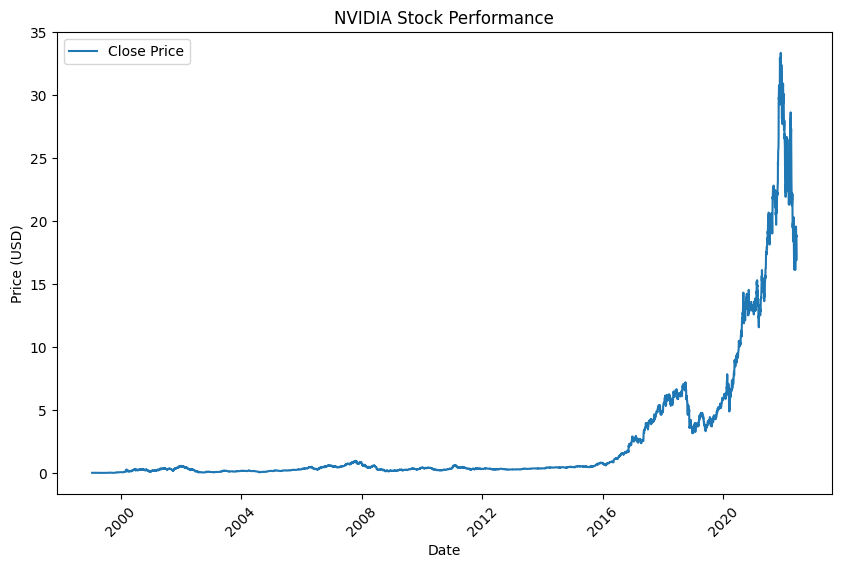

In [20]:
agent_executor.invoke({
    "input": "Create a line chart of NVIDIA stocks performance since it has been created",
})

In [27]:
agent_executor.invoke({
    "input": "What is the latest quarterly revenue of Tesla and what recent events have influenced it?"
})



> Entering new AgentExecutor chain...

I will first search for Tesla's latest quarterly revenue. Then, I will search for recent events that have influenced Tesla's revenue.
{'tool_name': 'internet_search', 'parameters': {'query': 'Tesla latest quarterly revenue'}}
[{'url': 'https://finance.yahoo.com/quote/TSLA/financials/', 'content': 'Get the detailed quarterly/annual income statement for Tesla, Inc. (TSLA). Find out the revenue, expenses and profit or loss over the last fiscal year.'}, {'url': 'https://ir.tesla.com/press-release/tesla-releases-fourth-quarter-and-full-year-2022-financial-results', 'content': "The webcast will be archived on the company's website following the call. AUSTIN, Texas, January 25, 2023 - Tesla has released its financial results for the fourth quarter and full year ended December 31, 2022 by posting an update on its Investor Relations website. Please visit https://ir.tesla.com to view the update."}, {'url': 'https://www.cnbc.com/2023/01/25/tesla-tsla-earni

{'input': 'What is the latest quarterly revenue of Tesla and what recent events have influenced it?',
 'output': "Tesla's latest quarterly revenue was $21.30 billion for Q1 2024, marking a decrease from the $23.33 billion recorded in Q1 2023. This reduction can be attributed to a combination of factors, including the company's decision to decrease the prices of its vehicles by up to 20% in reaction to competition in the global market for electric vehicles and rising inflation rates.",
 'citations': [CohereCitation(start=37, end=63, text='$21.30 billion for Q1 2024', documents=[{'url': 'https://www.nasdaq.com/articles/teslas-q1-2024:-challenges-and-opportunities-on-the-road-ahead', 'content': "Tesla's total revenue for Q1 2024 reached $21.30 billion, marking a decrease from the $23.33 billion recorded in Q1 2023. This reduction can be attributed to a combination of elements, including ...", 'id': 'doc_6'}], document_ids={'doc_6'}),
  CohereCitation(start=75, end=127, text='decrease from